# remove  fraudulent workers, and aggregate scores of` remaining workers

In [1]:
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib as mpl
from scipy.stats import mode

In [54]:
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

dbname = 'urx'
username = 'noahburbank'

engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))

In [97]:
# import worker data 
# connect:
con = None
con = psycopg2.connect(database = dbname, user = username)

#adjust for experiment 
# query:
sql_query = """
SELECT * FROM worker_table_exp2;
"""
workers = pd.read_sql_query(sql_query,con)

print workers.columns

Index([u'index', u'_worker_id', u'job_count', u'variance', u'mean',
       u'diversity_score', u'minority_percentage', u'is_bad',
       u'is_bad_cluster'],
      dtype='object')


In [98]:
# import score data
# choose the data from the relevant experiment 
#raw_df = pd.read_csv('experiment1_data.csv')
raw_df = pd.read_csv('experiment2_data.csv')

## First get rid of the fraudsters

In [99]:
old_length = len(raw_df)

# create set of bad worker ids
for group in workers.groupby('is_bad'):
    if group[0] == 1:
        bad_id_list = list(group[1]['_worker_id'])
        bad_id_set = set(bad_id_list)

# identify the rows from bad workers
raw_df['bad_worker'] = raw_df['_worker_id'].apply(lambda x: x in bad_id_set)

# remove those rows 
raw_df = raw_df[raw_df['bad_worker'] == 0]

new_length = len(raw_df)

print 'you are only losing :'
print (1 - float(new_length)/old_length) * 100
print 'percent of your data!!!'

you are only losing :
5.91715976331
percent of your data!!!


# score the individual pub/ad pairs

In [100]:
## detect majority judgments (and how much of a majority)
# score each unit id base
plurality_judgment = dict()
job_count = {}

for line in raw_df.groupby('_unit_id'):
    unit_id = line[0]
    judgments = line[1]['please_make_your_relevancy_judgment']
    mode = judgments.mode()
    mode = int(mode[0])
    mode_count = 0
    judgment_count = 0
    for judgment in judgments:
        judgment_count += 1
        if judgment == mode:
            mode_count += 1
    plurality_percentage = (mode_count +0.0)/judgment_count
    job_count[line[0]] = judgment_count
    plurality_judgment[line[0]] = mode, plurality_percentage

In [101]:
# aggregate scores into a dataframe 
unit_id_scores = pd.DataFrame()
unit_id_scores['_unit_id'] = plurality_judgment.keys()
unit_id_scores['majority'] = zip(*plurality_judgment.values())[1]
unit_id_scores['score'] = zip(*plurality_judgment.values())[0]
unit_id_scores['judgments'] = job_count.values()

# sometimes 2 is the majority/plurality, but the .6 threshold eliminates them
unit_id_scores[unit_id_scores.score == 2]

,_unit_id,majority,score,judgments
162,866237364,0.555556,2,9
176,866237380,0.555556,2,9
261,866237476,0.500000,2,10
654,866237969,0.555556,2,9
675,866237994,0.375000,2,8
935,866238290,0.400000,2,10


# filter out those without a 60% majority

In [102]:
unit_id_scores['has_enough_majority'] = unit_id_scores['majority'].apply(lambda x: x >= .6) == 1

and you lose 49 pub/ad pairs
you now have 901 pub/ad pairs
you lose 458 more observations
you now have 8605 total observations


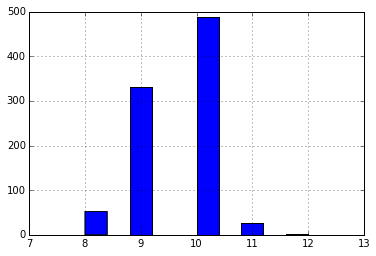

In [103]:
#identify those with and without a 60% majority
unit_id_scores['has_enough_majority'] = unit_id_scores['majority'].apply(lambda x: x >= .6) == 1
no_majority_unit_id_set = set(unit_id_scores[unit_id_scores['has_enough_majority'] != 1]._unit_id)

# remove ad/pub pairs
old_pair_count = len(unit_id_scores._unit_id.unique())

unit_id_scores = unit_id_scores[unit_id_scores['has_enough_majority'] == 1]
new_pair_count = len(unit_id_scores._unit_id.unique())
lost_pairs = old_pair_count - new_pair_count

print 'and you lose ' + str(lost_pairs) + ' pub/ad pairs'
print 'you now have ' + str(len(unit_id_scores)) + ' pub/ad pairs'

# hist
unit_id_scores['judgments'].apply(lambda x: x if (x>5) else False).hist()

# remove observations 
old_num_obs = len(raw_df)
raw_df['lack_of_majority'] = raw_df['_unit_id'].apply(lambda x: x in no_majority_unit_id_set)
raw_df = raw_df[raw_df['lack_of_majority'] != 1]
new_num_obs = len(raw_df)
lost_observations = old_num_obs - new_num_obs

print 'you lose ' + str(lost_observations) + ' more observations'
print 'you now have ' + str(new_num_obs) + ' total observations'

In [106]:
# remove the underscored elements 
unit_id_scores['min_job_req'] = unit_id_scores['judgments'].apply(lambda x: 1 if (x>4) else 0)
new_df = unit_id_scores[unit_id_scores['min_job_req'] == True]
print new_df.shape
print unit_id_scores.shape
if len(new_df) == len(unit_id_scores):
    print "no loss additional loss from pub/ad pairs with insufficient worker counts" 

(901, 6)
(901, 6)
no loss additional loss from pub/ad pairs with insufficient worker counts


### output to database

In [11]:
# output to unit pair scores table

# put this into the database, so that i don't need to process it each time, 
#becuase it is very slow
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

dbname = 'urx'
username = 'noahburbank'

engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))

In [12]:
# adjust to make sure you have the right experiment for the database 
unit_id_scores.to_sql('scores_exp1', engine, if_exists = 'replace')

# output as csv as well for conveineience needs 
unit_id_scores.to_csv('scores_exp2.csv')